In [44]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [16]:
MAX_SEQUENCES_LENGTH = 100 # Maximum kata pada kalimat
MAX_NB_WORDS = 5000 # Vocabulary size
input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)) = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [2]:
# open dataset,save on dataframe
df = pd.read_csv("dataset.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,created_at,screen_name,text,Label
0,5/1/2021 16:48,theoholan,itu mah konflik rebutan tanah,0
1,5/2/2021 1:38,knb_rmdhna,Karena ga ada urgensinya. Ga ada ancaman inva...,0
2,5/2/2021 5:51,_afaz,ini valid ð¯ kemarin saya smpat nonton sala...,0
3,5/2/2021 7:19,PolitikBRIN,Analisis yang dirumuskan dari Klaster Politik...,0
4,5/3/2021 14:12,KoloElang,Bisa tidak? Palestina taat secara kaffah dala...,0


In [3]:
# drop column created_at and screen_name
df = df.drop(['created_at', 'screen_name'], axis=1)

In [4]:
# Pre-Processing dataset
# fungsi case folding dan menghapus RT dan CC
def casefoldingRemoveRt(text):
     # menghapus RT (reetwet)
    text = re.sub(r'^[RT]+', '', text) 
    # case folding (menjadi lower case)
    text = text.lower()
    # menghapus CC (carbon copy)
    text = re.sub(r'^[cc]+', '', text)
    return text

# fungsi untuk menghapus noise
def removeNoise(text): 
    # menghapus unicode
    text = re.sub(r'(\\u[0-9A-Fa-f]+)','', text)
    # menghapus emoticon
    text = re.sub(r'[^\x00-\x7f]','',text)
    # menghapus url
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text) 
    # menghapus # (biasanya utk menandai topik tertentu)
    text = re.sub(r'#([^\s]+)', '', text) 
    # menghapus "@users"
    text = re.sub('@[^\s]+','',text)
    return text

# mengganti kata2 slang menjadi lebih baku
slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def removePunctuation(text): 
    # menghapus integers/numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # khusus untuk tanda baca ' (dirapatkan dengan text)
    text = re.sub("'",'',text)
    # menghapus punctuation (tanda baca)
    text = re.sub(r"[^A-Za-z]+"," ",text)
    # menghapus 1 karakter
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    # menghapus whitespace
    text = ' '.join(text.split())
    return text

In [5]:
df['text'] = df['text'].apply(lambda x: casefoldingRemoveRt(x))
df['text'] = df['text'].apply(lambda x: removeNoise(x))
df['text'] = df['text'].apply(lambda x: replaceSlang(x))
df['text'] = df['text'].apply(lambda x: removePunctuation(x))

In [6]:
df.head()

,text,Label
0,itu mah konflik rebutan tanah,0
1,karena tidak ada urgensinya tidak ada ancaman ...,0
2,ini sah kemarin saya smpat nonton salah satu w...,0
3,analisis yang dirumuskan dari klaster politik ...,0
4,bisa tidak palestina taat secara kaffah dalam ...,0


In [7]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['text'], inplace=True)

In [8]:
# delete data duplicate
df.drop_duplicates(subset='text', keep = 'first', inplace = True)

In [ ]:
# convert to CSV
# df.to_csv('clean1.csv', encoding='utf-8', index=False)

In [9]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [11]:
print('Found %d unique words.' % len(word_index))

Found 3129 unique words.


In [17]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [12]:
# Prepare to y as label
y = df["Label"]
y = to_categorical(y)

In [37]:
classes = ['0', '1', '2']

In [18]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [19]:
# Menyimpan dataset yg sudah di split agar bisa di panggil kembali
import pickle
with open('split_dataset/datset70.pickle', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [ ]:
# Membuka dataset yg telah di panggil di file local
# with open('pengujian/final/split_dataset/datset60.pickle', 'rb') as f:
#     X_train80, X_test80, y_train80, y_test80 = pickle.load(f)

In [22]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [23]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [24]:
# jumlah kata yg berhasil di embedding
hits

2858

In [25]:
# jumlah kata yg miss tidak ada dalam vector glove
misses

271

In [26]:
# kata-kataa yang tidak berhasil di bobot
index

['kadrun',
 'israhell',
 'covid',
 'ngerasa',
 'gegara',
 'mmng',
 'kyknya',
 'komenannya',
 'colonialisme',
 'ngerebut',
 'sygnya',
 'berjihat',
 'komplik',
 'jelasin',
 'laknatulloh',
 'penddk',
 'nitizen',
 'berundin',
 'terorist',
 'drun',
 'laknatullah',
 'akungaji',
 'waloni',
 'diglorifikasi',
 'urgensinya',
 'smpat',
 'radikalis',
 'memlerbaiki',
 'ketidakpercayaan',
 'jarusalem',
 'alfatehah',
 'urusin',
 'mengkerdilkan',
 'penyelesaiian',
 'kobisa',
 'konfl',
 'ngelihat',
 'tundukan',
 'berenti',
 'diselesaika',
 'soekarnois',
 'kliatan',
 'dipalestina',
 'tepewen',
 'cenderu',
 'alaqsa',
 'amiinnnn',
 'melulul',
 'blakangan',
 'mengingatkanku',
 'nyerang',
 'wkwkwk',
 'nyuplai',
 'ngehajar',
 'yudae',
 'ngometarin',
 'ngelawan',
 'diselesai',
 'gapaham',
 'gilaa',
 'kejatahan',
 'gapernah',
 'gajelas',
 'ningkatin',
 'ledakin',
 'ginian',
 'nyinyiran',
 'sampin',
 'ngeluarin',
 'nentuin',
 'mantengin',
 'pejuh',
 'mangap',
 'bernarasi',
 'blablabla',
 'jihat',
 'sehitam',
 '

In [28]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=False)

In [29]:
# Create Model CNN
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64,activation="relu"))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [30]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           156500    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [31]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
17/17 [==============================] - 15s 38ms/step - loss: 1.0101 - accuracy: 0.5024 - val_loss: 0.9798 - val_accuracy: 0.5022
Epoch 2/40
17/17 [==============================] - 0s 13ms/step - loss: 0.8752 - accuracy: 0.5906 - val_loss: 0.9210 - val_accuracy: 0.5109
Epoch 3/40
17/17 [==============================] - 0s 10ms/step - loss: 0.7436 - accuracy: 0.6951 - val_loss: 0.9118 - val_accuracy: 0.5371
Epoch 4/40
17/17 [==============================] - 0s 10ms/step - loss: 0.6038 - accuracy: 0.7405 - val_loss: 0.9447 - val_accuracy: 0.5546
Epoch 5/40
17/17 [==============================] - 0s 8ms/step - loss: 0.4841 - accuracy: 0.8217 - val_loss: 1.0552 - val_accuracy: 0.5459
Epoch 6/40
17/17 [==============================] - 0s 8ms/step - loss: 0.3775 - accuracy: 0.8614 - val_loss: 1.0614 - val_accuracy: 0.5415
Epoch 7/40
17/17 [==============================] - 0s 8ms/step - loss: 0.2796 - accuracy: 0.9131 - val_loss: 1.0883 - val_accuracy: 0.5240
Epoch 8/40
17/1

In [ ]:
# visualisasi model
# from keras.utils.vis_utils import plot_model
# plot_model(cnn_model, to_file='model1.png', show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=True, ddpi=96)

In [ ]:
# save model cnn
# cnn_model.save('model70_e40.h5')

# load model
# from keras.models import load_model

# cnn_model = load_model('pengujian/model70_e40.h5')

CNN Accuracy: 0.5152838427947598


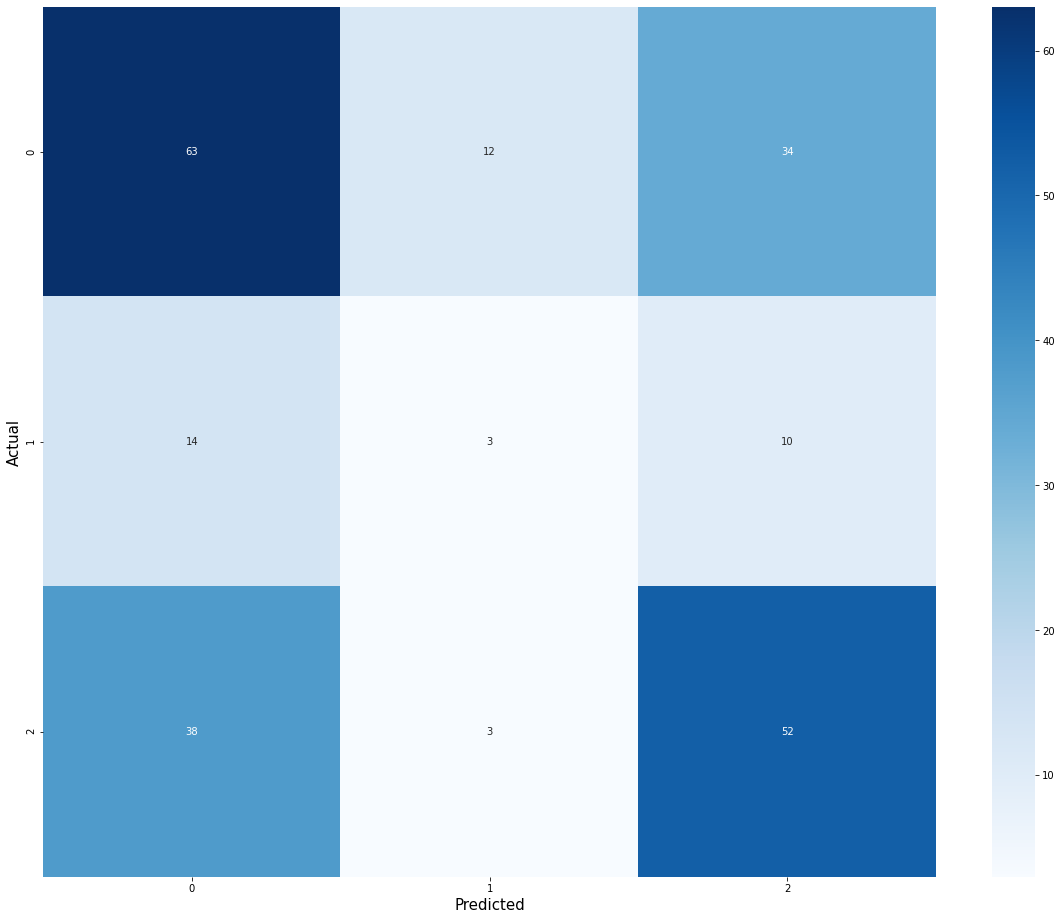

In [46]:
# benerin dulu
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [43]:
cnn_cn

array([[63, 12, 34],
       [14,  3, 10],
       [38,  3, 52]])

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56       109
           1       0.17      0.11      0.13        27
           2       0.54      0.56      0.55        93

    accuracy                           0.52       229
   macro avg       0.42      0.42      0.42       229
weighted avg       0.50      0.52      0.51       229



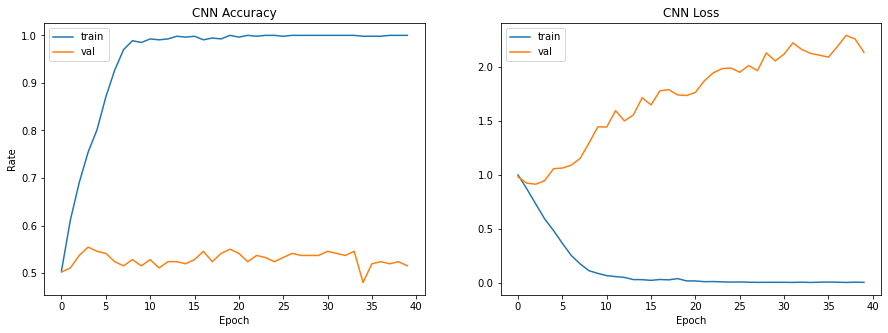

In [41]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
# word cloud